# TODO LIST

- [x] Choose Amsterdam / Rotterdam via parameter
- [ ] Add Lags for remaining districts
- [ ] Add / Replace `abs` values with `diff`
  - [x] Replace `lagged` variables with `diff`
  - [ ] Replace target variable with its `diff`
- [ ] Look-ahead values (e.g. 1 min 5 min 10 min 30 min) (tunable)
- [ ] Confusion Matrix per bin - find out model inaccuracies
- [ ] Add `LightGBM` model
- [ ] Benchmark accuracy, train-time, inference-time (in progress)
- [x] Add data from more than 1 days


In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from helper import cyclic_encode

In [16]:
df = pd.read_csv("data/processed/most_crowded.csv")

In [17]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

## Feature Extraction

1. Binning
2. Time-related Features
   1. Extraction
      1. Hour
      2. Minute
      3. Day of week
   2. Cyclic Encoding
3. Lagged Features
   1. 1-10 Minutes
   2. 15 Minutes
   3. 30 Minutes
   4. 60 Minutes
4. Rolling Mean Features
   1. Mean
   2. Std
   3. Var
   4. Kurtosis
   5. Skewness
5. Exponential Smoothing Features
   1. 5 Minutes
   2. 10 Minutes
   3. 15 Minutes
   4. 30 Minutes
   5. 60 Minutes


##### Binning


In [18]:
mean_crowd = df["crowd"].mean()
std_crowd = df["crowd"].std()

# Define bins based on mean and standard deviation
bins = [
    float("-inf"),
    mean_crowd - 1.0 * std_crowd,
    mean_crowd - 0.5 * std_crowd,
    mean_crowd + 0.5 * std_crowd,
    mean_crowd + 1.0 * std_crowd,
    float("inf"),
]

# Define labels for the bins
labels = list(range(len(bins) - 1))

In [19]:
c_lvl = pd.cut(
    df["crowd"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    ordered=True,
).astype(np.uint16)

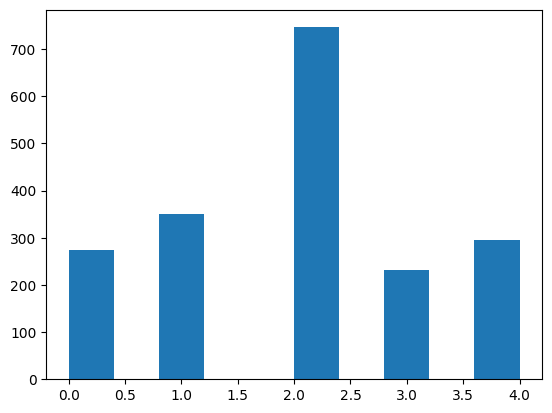

In [20]:
# Plot histogram of c_lvl in order to check if there is a class imbalance
plt.hist(c_lvl)
plt.show()

In [21]:
# c_lvl = c_lvl.sub(c_lvl.shift().fillna(0)).astype(int)
# c_lvl = c_lvl.add(abs(c_lvl.min()))
df["c_lvl"] = c_lvl

Time-related Feature Extraction


In [22]:
# Time-related features
time_related_features = {
    "hour": df["timestamp"].dt.hour.astype(np.uint8),
    "day_of_week": df["timestamp"].dt.day_of_week.astype(np.uint8),
    "minute": df["timestamp"].dt.minute.astype(np.uint8),
    "is_weekend": (df["timestamp"].dt.weekday >= 5).astype(np.uint8),
}

Lagged and Rolling Feature Extraction


In [23]:
# Lagged features
lagged_features = {
    f"lag_{i}": df["crowd"].shift(i).diff() for i in list(range(1, 11)) + [15, 30, 60]
}

# Rolling features
rolling_features = {
    f"rolling_{stat}_{window}": getattr(df["crowd"].rolling(window=window), stat)()
    for window in [5, 10, 15, 30, 60]
    for stat in ["mean", "std", "var", "skew", "kurt"]
}

# Exponential smoothing
exp_smoothing_features = {
    f"ema_{window}": df["crowd"].ewm(com=0.25).mean() for window in [5, 10, 15, 30, 60]
}

In [24]:
lagged_df = (
    df.assign(
        **time_related_features,
        **lagged_features,
        **rolling_features,
        **exp_smoothing_features
    )
    .drop(columns="crowd")
    .set_index("timestamp")
    .dropna()
)

lagged_df = cyclic_encode(lagged_df, "minute", 60)
lagged_df = cyclic_encode(lagged_df, "hour", 24)
lagged_df = cyclic_encode(lagged_df, "day_of_week", 7)

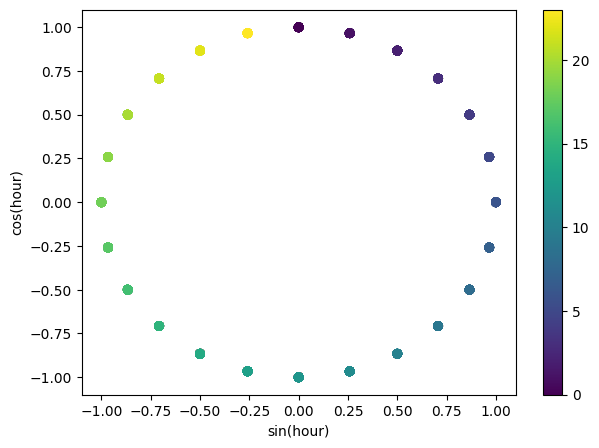

In [25]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(lagged_df["hour_sin"], lagged_df["hour_cos"], c=lagged_df["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

In [26]:
lagged_df.drop(columns=["minute", "hour", "day_of_week"], inplace=True)

In [27]:
lagged_df.tail(10)

,c_lvl,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,ema_10,ema_15,ema_30,ema_60,minute_sin,minute_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-04-18 03:59:04.423477411,4,0,-14.0,-16.0,11.0,11.0,16.0,4.0,-43.0,-3.0,...,222.065913,222.065913,222.065913,222.065913,-0.104528,0.994522,0.707107,0.707107,0.433884,-0.900969
2024-04-18 04:02:20.307244062,4,0,23.0,-14.0,-16.0,11.0,11.0,16.0,4.0,-43.0,...,242.813183,242.813183,242.813183,242.813183,0.207912,0.978148,0.866025,0.500000,0.433884,-0.900969
2024-04-18 04:05:18.782693624,4,0,22.0,23.0,-14.0,-16.0,11.0,11.0,16.0,4.0,...,247.762637,247.762637,247.762637,247.762637,0.500000,0.866025,0.866025,0.500000,0.433884,-0.900969
2024-04-18 04:08:17.035126686,4,0,1.0,22.0,23.0,-14.0,-16.0,11.0,11.0,16.0,...,235.952527,235.952527,235.952527,235.952527,0.743145,0.669131,0.866025,0.500000,0.433884,-0.900969
2024-04-18 04:11:15.694185495,4,0,-16.0,1.0,22.0,23.0,-14.0,-16.0,11.0,11.0,...,231.190505,231.190505,231.190505,231.190505,0.913545,0.406737,0.866025,0.500000,0.433884,-0.900969
2024-04-18 04:14:13.092746735,3,0,-3.0,-16.0,1.0,22.0,23.0,-14.0,-16.0,11.0,...,223.838101,223.838101,223.838101,223.838101,0.994522,0.104528,0.866025,0.500000,0.433884,-0.900969
2024-04-18 04:17:08.512792110,4,0,-8.0,-3.0,-16.0,1.0,22.0,23.0,-14.0,-16.0,...,236.767620,236.767620,236.767620,236.767620,0.978148,-0.207912,0.866025,0.500000,0.433884,-0.900969
2024-04-18 04:20:02.966425896,4,0,18.0,-8.0,-3.0,-16.0,1.0,22.0,23.0,-14.0,...,250.553524,250.553524,250.553524,250.553524,0.866025,-0.500000,0.866025,0.500000,0.433884,-0.900969
2024-04-18 04:23:02.783959389,3,0,14.0,18.0,-8.0,-3.0,-16.0,1.0,22.0,23.0,...,227.710705,227.710705,227.710705,227.710705,0.669131,-0.743145,0.866025,0.500000,0.433884,-0.900969


#### Data Splitting


In [28]:
X = lagged_df.drop(columns=["c_lvl"])
y = lagged_df["c_lvl"]

### Model Training

1. Pipeline Construction
2. Hyperparameter Tuning
3. Time Series Cross Validation


In [29]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

#### Pipeline Construction


In [30]:
num_features = X_train.select_dtypes(include=[np.float64]).columns.tolist()

In [31]:
from sklearn.preprocessing import OneHotEncoder


preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), num_features),
        ("one-hot", OneHotEncoder(handle_unknown="ignore"), ["is_weekend"]),
    ],
    remainder="passthrough",
)

# Define the pipeline
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("estimator", XGBClassifier(random_state=42)),
    ]
)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_15', 'lag_30',
                                                   'lag_60', 'rolling_mean_5',
                                                   'rolling_std_5',
                                                   'rolling_var_5',
                                                   'rolling_skew_5',
                                                   'rolling_kurt_5',
                                                   'rolling_mean_10',
                                                   'rolling_std_10',
                                                   'rolling...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

##### Grid Search


In [32]:
param_grid = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__max_depth": [2, 3],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__colsample_bytree": [0.5, 0.7, 0.8],
    "estimator__reg_lambda": [0.3, 0.5, 0.7],
}

In [18]:
ts_cv = TimeSeriesSplit(n_splits=5)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_micro": make_scorer(f1_score, average="micro"),
}


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=ts_cv,
    scoring=scoring,
    refit="f1_micro",
    n_jobs=1,
    verbose=1,
)
grid_search.fit(X_train, y_train)

print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters:")
for key, value in grid_search.best_params_.items():
    print(f"    - {key.split('__')[-1]}: {value}")

cv_results = grid_search.cv_results_

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best score: 0.870
Best parameters:
    - colsample_bytree: 0.7
    - learning_rate: 0.1
    - max_depth: 3
    - n_estimators: 50
    - reg_lambda: 0.3


In [19]:
best_model = grid_search.best_estimator_

In [20]:
for key, value in cv_results.items():
    if key.startswith(("mean_test", "test")):
        metric = key.split("_")[-1]
        print(f"{metric}: {value.mean():.3f} ± {value.std():.3f}")

accuracy: 0.854 ± 0.010
micro: 0.854 ± 0.010


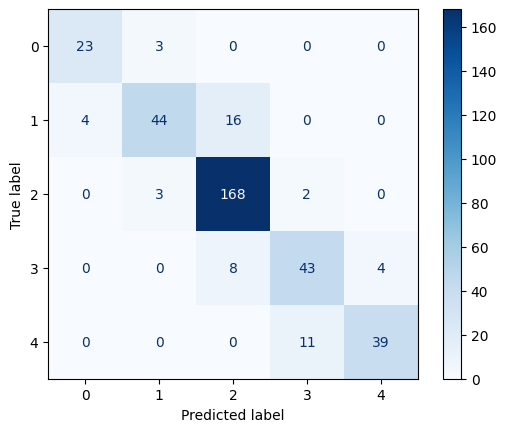

In [21]:
y_pred = best_model.predict(X_test)
_ = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")

In [30]:
print(
    classification_report(
        y_test,
        y_pred,
        digits=3,
        target_names=["very_low", "low", "medium", "high", "very_high"],
    )
)

              precision    recall  f1-score   support

    very_low      0.852     0.885     0.868        26
         low      0.885     0.719     0.793        64
      medium      0.884     0.971     0.926       173
        high      0.786     0.800     0.793        55
   very_high      0.930     0.800     0.860        50

    accuracy                          0.872       368
   macro avg      0.867     0.835     0.848       368
weighted avg      0.874     0.872     0.870       368



# Model Evaluation

1. w/ `Feature Selection` (34 Features)
   1. Diff Lags + Rolling Stats
      1. Accuracy: 0.492 ± 0.010
      2. F1: 0.360 ± 0.027
   2. Diff Lags + Rolling Stats + EMA
      1. Accuracy: 0.484 ± 0.009
      2. F1: 0.339 ± 0.028
2. w/out `Feature Selection` (52 Features)
   1. Diff Lags + Rolling Stats + EMA
      1. Accuracy: 0.854 ± 0.01
      2. F1-Micro: {0.854 ± 0.01}
